> Once we have accurately calculated the expected returns and volatility of the ETFs, we want to find a way to best invest amongst the different ETFs. Below, we show the data of some of the ETFs we have in our fund. ___How would you decide to allocate amongst these funds?___

Portfolio optimization problem 
- asset distribution


> Suppose now that the client believes the USD is likely to depreciate and hence wants to reduce his exposure to the currency. ___How would you design a portfolio that fulfills his requirements?___

Files:
1. asset_classes.csv
2. covariance_matrix.csv
3. asset_class_currency_exposure.csv

---

1. https://www.youtube.com/watch?v=KDw3hC2YNFc
1. https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9
1. https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

---

## MPT

- MPT (mean-variance analysis) / Markowitz model
- maximize the return for a given amount of risk
- gauge the risk of portfolio by measuring the volatility as a proxy

- port. expected return
- volatility = s.d.
- sharpe ratio
- plot efficient frontier curve

     ticker  return      sd  div_yield  expense_ratio
0    IVV_US  0.0552  0.1630     0.0198         0.0003
1    VGK_US  0.0686  0.1542     0.0226         0.0008
2   AAXJ_US  0.0384  0.1758     0.0254         0.0068
3    EWA_US  0.0697  0.1460     0.0403         0.0050
4    EWC_US  0.0295  0.1781     0.0264         0.0049
5    EWJ_US -0.0089  0.2269     0.0242         0.0049
6   SPEM_US  0.0540  0.2240     0.0385         0.0011
7    BIL_US  0.0152  0.0011     0.0205         0.0014
8    SHY_US  0.0195  0.0130     0.0194         0.0015
9   SCHR_US  0.0183  0.0453     0.0212         0.0005
10   VNQ_US  0.0618  0.2293     0.0413         0.0012
11  VNQI_US  0.0103  0.2489     0.0758         0.0012
12   GLD_US  0.0481  0.1291     0.0000         0.0040


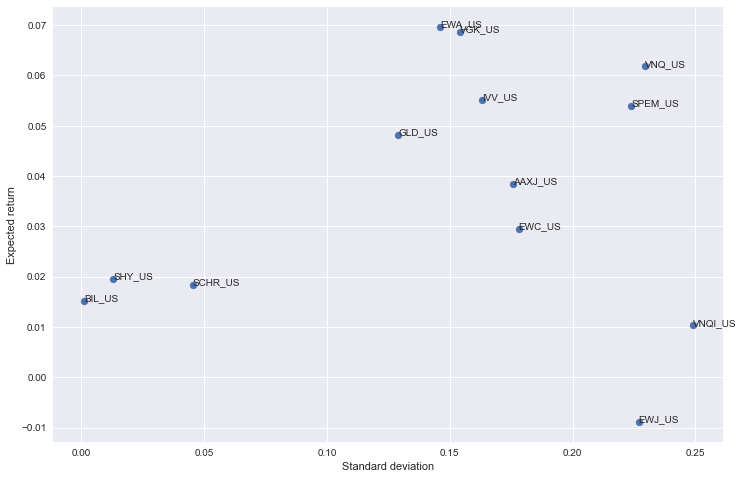

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean data: tab-separated
ast = pd.read_csv('csv/asset_classes.csv', sep='\t')

#rename
ast.columns = ['asset', 'ticker', 'return', 'sd', 'div_yield', 'expense_ratio']

# clean up ticker
ast['ticker'] = ast['ticker'].replace(' ', '_', regex=True)

# convert % string to float
ast['return'] 		 = ast['return'].replace('%','',regex=True).astype('float')/100
ast['sd'] 			 = ast['sd'].replace('%','',regex=True).astype('float')/100
ast['div_yield'] 	 = ast['div_yield'].replace('%','',regex=True).astype('float')/100
ast['expense_ratio'] = ast['expense_ratio'].replace('%','',regex=True).astype('float')/100

# drop column 'asset'
ast = ast.drop(columns=['asset'])

print(ast)

plt.figure(figsize=(12,8))
plt.style.use('seaborn')

plt.scatter(ast['sd'], ast['return'])
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')

# annotate label 
for i, txt in enumerate(ast['ticker']):
    plt.annotate(txt, (ast['sd'][i], ast['return'][i]))

### Simulate portfolios + plot efficient frontier

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.03576545 0.03394326 0.03213676 ... 0.03536359 0.03582804 0.03851057]


Text(0, 0.5, 'Return')

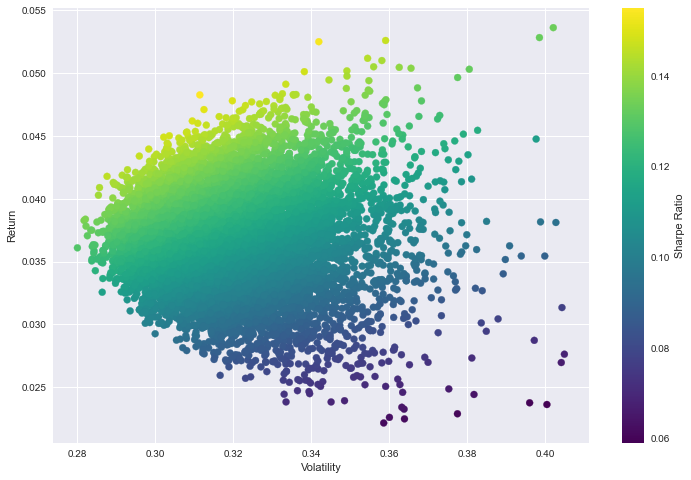

In [120]:
np.random.seed(42)
num_ports = 10000
all_weights = np.zeros((num_ports, 13)) 
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

print(all_weights[0])

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(13))
    weights = weights/np.sum(weights) # ensure sum of weights = 1
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (ast['return'] * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, weights))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    

print(ret_arr)

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
